In [1]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import random

import nxsdk.api.n2a as nx

from nxsdk.utils.plotutils import plotRaster
from msj_brain.asynch_eval import Callable

In [2]:
n_inputs = 512

net = nx.NxNet()
# fourier weights
# non leaky neurons... 
# change bias after charging phase
inputs = net.createSpikeGenProcess(numPorts=n_inputs)

nonlif = []
nonlif_g = net.createCompartmentGroup()
for i in range(n_inputs*2):
    nonlif_p = nx.CompartmentPrototype(vThMant=2000,
                                       biasMant = 0,
                                       biasExp = 6,
                                       compartmentCurrentDecay=4095,
                                       compartmentVoltageDecay=0,
                                       functionalState=2,
                                       logicalCoreId=int(i/32))
    nonlif.append(net.createCompartment(prototype=nonlif_p))
nonlif_g.addCompartments(nonlif)

# Connect spike generator to compartment
inputs_nonlif = nx.ConnectionPrototype()

def fourier_weight_mask():
    k, n = np.mgrid[0:n_inputs, 0:n_inputs]
    theta = 2 * np.pi * k * n / n_inputs
    return np.hstack([np.cos(theta), -np.sin(theta)])

weight_mask = fourier_weight_mask()

print(weight_mask.shape)
inputs.connect(nonlif_g, prototype=inputs_nonlif, weight=weight_mask.T)


numSteps = 1500

spiking_choices = np.arange(0,(n_inputs*2)-1,2)
spiking_times = []
for i in range(n_inputs):
    spiking_times.append(random.randint(0,n_inputs*2))
    
v_probes = []

for i in range(n_inputs):
    inputs.addSpikes(i, [spiking_times[i]])
    v_probes.append(nonlif_g.probe(nx.ProbeParameter.COMPARTMENT_VOLTAGE)[0][i])


compiler = nx.N2Compiler()
board = compiler.compile(net)

(512, 1024)


In [3]:
# directory where SNIP C-code
includeDir = os.getcwd()
# Create SNIP
mgmtSnip = board.createProcess(
    name="runMgmt",
    includeDir=includeDir,
    cFilePath=includeDir + "/setVTh_net.c", # NxCore level C file
    funcName="runMgmt",
    guardName="doRunMgmt",
    phase="mgmt")

# channel: super host to Lakemont - new vTh values
# channel name: vThChannel, elements type: int, max capacity: 1 element
vThChannel = board.createChannel(b'vThChannel', "int", 1)
# Sending process is the super host (denoted by None) with mgmtSnip as the receiving process
vThChannel.connect(None, mgmtSnip)

# channel: Lakemont to super host - time of modification
# channel name: timeChannel, element type: int, max capacity: 1 element
timeChannel = board.createChannel(b'timeChannel', "int", 1)
# Sending process is the mgmtSnip and the receiving process is the super host (denoted by None)
timeChannel.connect(mgmtSnip, None)

# Start driver
board.startDriver()

/home/negin/miniconda2/envs/loihi/lib/python3.5/site-packages/ipykernel_launcher.py:10: NxDeprecationWarning: createProcess will be removed in 0.9 in favor of createSnip
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
times = []

# Add initial element in channel otherwise snip might miss it before Python on super host gets to send next element
vThChannel.write(1, [0])

# Launch execution
board.run(numSteps, aSync=True)
#net.runAsynch(numSteps=cycles*100)

# Read time of last vTh modification from channel and write next vTh value to channel

#dt = 10
#numSteps = 1000
#gen_a.addSpikes(0, [200])
#gen_b.addSpikes(0, [500])

#motor_position_in.sendSpikes(spikeInputPortNodeIds=(act_angles[i]), numSpikes=1)

bias = 0

#for i in range(numSteps):
#    times.append(timeChannel.read(1)[0])
#    if i == 20:
#        bias += int(100/64)
#    if i == 50:
#        bias += int(50/64)
#    if i == 72:
#        bias = 0
#    vThChannel.write(1, [bias])

# Finish and disconnect
board.finishRun()
board.disconnect()


INFO:DRV:  Connecting to 127.0.0.1:44423
INFO:DRV:      Host server up..............Done 0.03s
INFO:DRV:      Encoding axons/synapses.....Done 0.84s
INFO:DRV:      Compiling Embedded snips....Done 0.12s
INFO:HST:  Using Kapoho Bay serial number 435
INFO:HST:  Args chip=0 cpu=0 /home/negin/miniconda2/envs/loihi/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1621868040.695303/launcher_chip0_lmt0.bin --chips=1 --remote-relay=0 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 3.32s
INFO:DRV:      Encoding probes.............Done 1.09s
INFO:DRV:      Transferring probes.........Done 5.27ms
INFO:DRV:      Configuring registers.......Done 1.93s
INFO:DRV:      Transferring spikes.........Done 0.72ms


In [ ]:
plt.figure(1, figsize=(18,10))
for i in range(n_inputs):
    v_probes[i].plot()

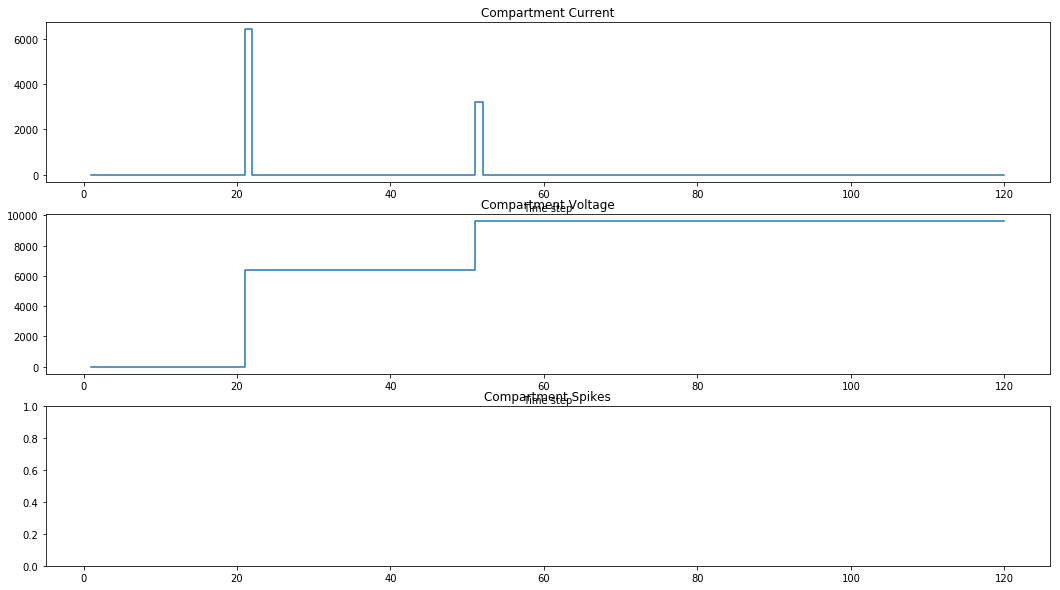

In [5]:
# Add initial and final values to 'times' and 'vThVals' that have not been sent for plotting
times.insert(0, 0)
times.append(1000)
#vThVals.insert(0, 150)
#vThVals.insert(0, 150)
#vThVals = vThVals[:-1]

# Helper method to draw vertical interval separators whenever we change vTh
def drawIntervalSeperators(intervalBoundaries):
    for t in intervalBoundaries:
        plt.axvline(x=t, color='k', linestyle='--')

# Plot compartment current, voltage and spikes
plt.figure(2, figsize=(18,10))

ax1 = plt.subplot(3, 1, 1)
u.plot()
plt.title('Compartment Current')
#drawIntervalSeperators(times)

ax2 = plt.subplot(3, 1, 2)
v.plot()
plt.title('Compartment Voltage')
#plt.step(times, np.array(vThVals)*2**6, color='r', linestyle='--')

ax3 = plt.subplot(3, 1, 3)
s.plot()
plt.title('Compartment Spikes')
#drawIntervalSeperators(times)
ax3.set_xlim(ax1.get_xlim())

plt.show()